## Basic Usage

`TODO: More detail`

### 1. Get an example dataset.

In [1]:
from clairvoyance2.datasets import dummy_dataset

data = dummy_dataset(
    n_samples = 100,
    temporal_covariates_n_features = 5,
    temporal_covariates_max_len = 30,
    temporal_covariates_missing_prob = 0.1,
    static_covariates_n_features = 4,
    static_covariates_missing_prob = 0.0
)

Dataset components (temporal and static covariates) can be seen with their corresponding feature dimensions listed.

In [2]:
data

Dataset(
    temporal_covariates=TimeSeriesSamples([100,*,5]),
    static_covariates=StaticSamples([100,4]),
)

Preview temporal covariates.

In [3]:
data.temporal_covariates

TimeSeriesSamples() with data:
                    0         1         2         3         4
s_idx t_idx                                                  
0     0      0.419045  0.893763  0.780285  0.660508  1.047522
      1      1.257931  2.172271       NaN  2.360713  1.981578
      2      2.247657       NaN  2.525946       NaN  2.897191
      3      3.396456  5.386071       NaN  2.503248  3.517212
      4      4.387812  3.365264  5.612532  5.573375  4.767746
...
                    0         1         2         3         4
s_idx t_idx                                                  
99    0      0.534060  2.147206       NaN  0.303405  0.251866
      1      1.699425  1.186061  2.125171       NaN  1.950620
      2      2.711652  3.304597  3.211545  3.718128  2.838271
      3      3.361431  4.852409       NaN  1.191204  3.910778
      4      4.502795  4.500195  4.985458  2.131713       NaN

Plot temporal covariates for one sample (sample ID: `0`).

<AxesSubplot:xlabel='t_idx'>

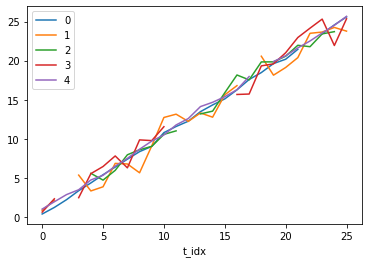

In [4]:
data.temporal_covariates[0].plot()

### 2. Pre-process your data.

* Use an imputer to impute missing values in the temporal covariates.
* Use a scaler to scale the temporal covariates in the `[0, 1]` range.

In [5]:
from clairvoyance2.imputation import TemporalDataDefaultImputer

imputer = TemporalDataDefaultImputer()

In [6]:
from clairvoyance2.preprocessing import TemporalDataMinMaxScaler

scaler = TemporalDataMinMaxScaler()
scaler

TemporalDataMinMaxScaler(
    params:
    {
        "apply_to": "temporal_covariates",
        "feature_range": [
            0,
            1
        ],
        "copy": True,
        "clip": False
    }
)

In [7]:
data = imputer.fit_transform(data)
data = scaler.fit_transform(data)

<AxesSubplot:xlabel='t_idx'>

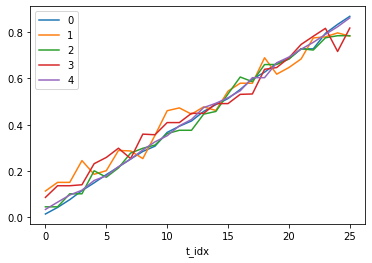

In [8]:
data.temporal_covariates[0].plot()

### Do N-step ahead prediction.

Fot this example, split out some of the temporal covariate features (labelled `[1, 4]`) as targets.
Features` [0, 1, 2]` will then be used as covariates for prediction.

In [9]:
from clairvoyance2.preprocessing import TemporalTargetsExtractor

data = TemporalTargetsExtractor(params=dict(targets=[1, 4])).fit_transform(data)
data

Dataset(
    temporal_covariates=TimeSeriesSamples([100,*,3]),
    static_covariates=StaticSamples([100,4]),
    temporal_targets=TimeSeriesSamples([100,*,2]),
)

<AxesSubplot:xlabel='t_idx'>

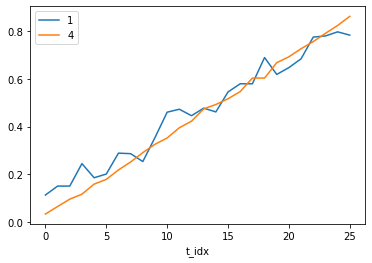

In [10]:
data.temporal_targets[0].plot()

Define a prediction model.

In [11]:
from clairvoyance2.prediction import RNNRegressor

predictor = RNNRegressor(params=dict(epochs=10))
predictor

RNNRegressor(
    params:
    {
        "rnn_type": "LSTM",
        "hidden_size": 100,
        "num_layers": 1,
        "bias": True,
        "dropout": 0.0,
        "bidirectional": False,
        "nonlinearity": null,
        "proj_size": null,
        "max_len": null,
        "optimizer_str": "Adam",
        "optimizer_kwargs": {
            "lr": 0.01,
            "weight_decay": 1e-05
        },
        "batch_size": 32,
        "epochs": 10,
        "use_past_targets": True,
        "ff_hidden_dims": [],
        "ff_out_activation": null,
        "padding_indicator": -999.0
    }
)

Choose number of N-steps ahead, here `1`, and fit the model.

In [12]:
from clairvoyance2 import NStepAheadHorizon

predictor.fit(data, horizon=NStepAheadHorizon(1));

Epoch: 0, Loss: 0.288144798129797
Epoch: 1, Loss: 0.19515693828463554
Epoch: 2, Loss: 0.07432992536574602
Epoch: 3, Loss: 0.05980007685720921
Epoch: 4, Loss: 0.03065473187714815
Epoch: 5, Loss: 0.03836615949869156
Epoch: 6, Loss: 0.017662691306322812
Epoch: 7, Loss: 0.012544937687925995
Epoch: 8, Loss: 0.010179792530834675
Epoch: 9, Loss: 0.00906221430748701


We can now make predictions.

<AxesSubplot:>

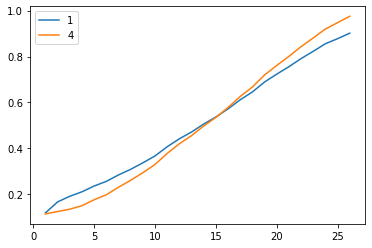

In [13]:
predicted_time_series = predictor.predict(data=data, horizon=NStepAheadHorizon(1))

predicted_time_series[0].plot()

Finally, to evaluate the results using a metric.

In [14]:
from clairvoyance2.metrics import rmse_t

metric = rmse_t(data.temporal_targets, predicted_time_series)
print(f"RMSE = {metric:.3f}")

RMSE = 0.046
